In [6]:
import h5py
import pandas as pd
from shapely.geometry import Polygon
from helper_functions import get_coords
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from IPython.display import Image

In [7]:
# aggregate_fittings = pd.read_hdf(
#     # "D:\Master\Granule-Explorer-Visualization-Tool\data\\aggregate_fittings_ml.h5", key="aggregate_data", mode="r"
#     # "D:\Master\Granule-Explorer-Visualization-Tool\data\\aggregate_fittings_ml.h5", key="fourier_terms", mode="r"
#     "D:\Master\Granule-Explorer-Visualization-Tool\data\\aggregate_fittings_ml.h5", key="fourier", mode="r"
# )
# aggregate_fittings['experiment'] = "ML_03_03_2024"
# aggregate_fittings.to_hdf("D:\Master\Granule-Explorer-Visualization-Tool\data\\aggregate_fittings_ml_renamed.h5", key="aggregate_data", mode="w")

# Compare fourier terms | IoU

In [8]:
# fourier_df_ML = pd.read_hdf(
#     "D:\Master\Granule-Explorer-Visualization-Tool\data\\2020-02-05_14.36.40--NAs--T1354-GFP_Burst_ml.h5", key="fourier", mode="r"
# )
# fourier_df = pd.read_hdf(
#     "D:\Master\Granule-Explorer-Visualization-Tool\data\\2020-02-05_14.36.40--NAs--T1354-GFP_Burst.h5", key="fourier", mode="r"
# )

In [9]:
fourier_pd_gradient = pd.read_hdf(
    "C:/Users/Endre/Desktop/Granule-Explorer-Visualization-Tool/data/2020-02-05_14.36.40--NAs--T1354-GFP_Burst.h5", key="fourier", mode="r"
    # "D:\Master\Granule-Explorer-Visualization-Tool\data\\2020-02-05_14.36.40--NAs--T1354-GFP_Burst.h5", key="fourier", mode="r"
)
fourier_pd_ml = pd.read_hdf(
    # "D:\Master\Granule-Explorer-Visualization-Tool\data\\2020-02-05_14.36.40--NAs--T1354-GFP_Burst_ML_FIXED.h5", key="fourier", mode="r"
    # "D:\Master\Granule-Explorer-Visualization-Tool\data\\2020-02-05_14.36.40--NAs--T1354-GFP_Burst_ml.h5", key="fourier", mode="r"
    "C:/Users/Endre/Desktop/Granule-Explorer-Visualization-Tool\data/2020-02-05_14.36.40--NAs--T1354-GFP_Burst_ML_FIXED.h5", key="fourier", mode="r"
)
fourier_pd_gradient_valid = fourier_pd_gradient[(fourier_pd_gradient['valid'] == True)]
fourier_pd_ml_valid = fourier_pd_ml[(fourier_pd_ml['valid'] == True)]

# fourier_pd_ml.iloc[302]

## Amount of valid granules

In [10]:
nr_valid = fourier_pd_gradient_valid['granule_id'].unique().size
print(f"Valid granules (gradient) | {nr_valid}")

nr_valid_ml = fourier_pd_ml_valid['granule_id'].unique().size
print(f"Valid granules (ML) | {nr_valid_ml}")

Valid granules (gradient) | 384
Valid granules (ML) | 423


In [11]:
# For all granule_id's
    # For each granule_id in frame
        # Calculate IoU

IoU = []
area_gradient_list = []
area_ml_list = []
granule_ids = []
frames = []

for frame_id in range(1000): # For all frames
    granules_in_gradient_frame = fourier_pd_gradient_valid[fourier_pd_gradient_valid['frame'] == frame_id]
    valid_granule_gradient_ids = granules_in_gradient_frame['granule_id'].unique() # All granules

    granules_in_frame_ml = fourier_pd_ml_valid[fourier_pd_ml_valid['frame'] == frame_id]
    # valid_granule_ids_ml = granules_in_frame_ml['granule_id'].unique() # All granules
    # print(valid_granule_ids)
    # print(valid_granule_ids_ml)
    # assert np.array_equal(valid_granule_ids, valid_granule_ids_ml), "Should always be equal"
    
    # Compare x,y positions to verify comparisons happen with correct granules, irrespective of their id's
    for granule_id in valid_granule_gradient_ids: # For all granules in frame
        
        granule_f_gradient_terms = granules_in_gradient_frame[granules_in_gradient_frame['granule_id'] == granule_id]

        granule_f_terms_ml = granules_in_frame_ml[granules_in_frame_ml['granule_id'] == granule_id]
        if granule_f_terms_ml.size == 0 :#or (granule_f_gradient_terms.iloc[0][['x','y']].tolist() != granule_f_terms_ml.iloc[0][['x','y']].tolist()):
            continue

        xs, ys = get_coords(granule_f_gradient_terms, get_relative=True)
        xy = np.vstack((xs,ys)).T
        area_gradient = Polygon(xy)


        # if (granule_f_gradient_terms.iloc[0][['x','y']].tolist() == granule_f_terms_ml.iloc[0][['x','y']].tolist()):
        xs_ml, ys_ml = get_coords(granule_f_terms_ml, get_relative=True) 
        xy = np.vstack((xs_ml,ys_ml)).T 
        area_ml = Polygon(xy) 
        intersection = area_gradient.intersection(area_ml).area / area_gradient.union(area_ml).area

        IoU.append(intersection)
        area_gradient_list.append(area_gradient.area)
        area_ml_list.append(area_ml.area)
        granule_ids.append(granule_f_gradient_terms.iloc[0]['granule_id'])
        frames.append(granule_f_gradient_terms.iloc[0]['frame'])
    #     if intersection < 0.68:
    #         print(f"Area {area_gradient.area} | Area_ml {area_ml.area} | IoU: {intersection} | Same Position: {granule_f_gradient_terms.iloc[0][['x','y']].tolist() == granule_f_terms_ml.iloc[0][['x','y']].tolist()}")
    #         fig = px.scatter(x=xs, y=ys)
    #         fig.add_trace(go.Scatter(x=xs, y=ys, marker=dict(color='red', size=16), name=f"100 p border {id}"))
    #         fig.add_trace(go.Scatter(x=xs_ml, y=ys_ml, marker=dict(color='yellow', size=16), name=f"100 p border {id}"))
    #         # fig.add_trace(go.Scatter(x=xs_ml, y=ys_ml, marker=dict(color='blue', size=2), mode="markers", name=f"100 p border {id}"))
    #         fig.show()
    #     break
    # break
    
df = pd.DataFrame({
    "area_gradient":area_gradient_list,
    "area_ml":area_ml_list,
    "IoU":IoU,
    "granule_ids": granule_ids,
    "frames": frames
})

In [12]:
df[df['IoU'] < 0.67]

,area_gradient,area_ml,IoU,granule_ids,frames
17962,113.534171,155.296847,0.669059,469,924
18211,116.870805,151.142482,0.662999,482,939


In [13]:
mean_IoU = df['IoU'].mean()
print(mean_IoU)
IoU_std = df['IoU'].std()
print(IoU_std)


0.9313515541416795
0.04335054982650376


Previous:

0.9196691274162706 <br>
0.05097715592981259

Small improvement in mean IoU (+0.01) and std (-0.01)

In [14]:
fig = px.violin(df["IoU"], y="IoU", title="IoU distribution", box=True, points="all")
fig.show()

Old distribution:

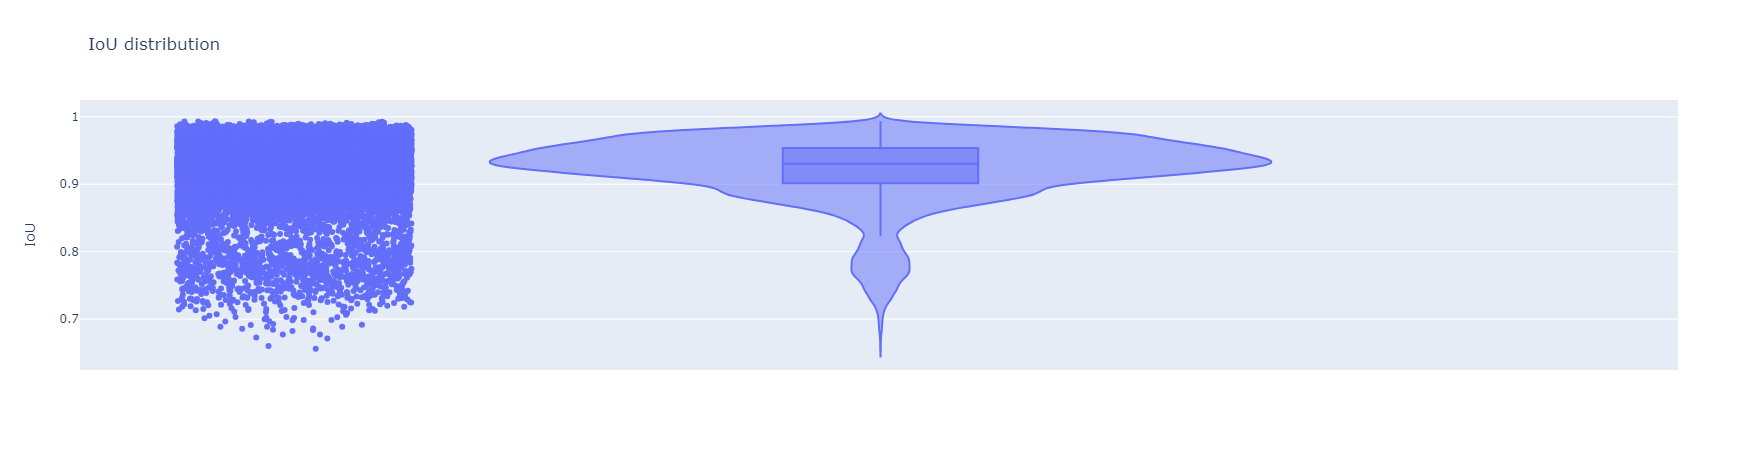

In [15]:
Image(filename='old_iou_dist.png') 

Make a histogram comparing the area of the ML and gradient. If it skews we have a bias towards making bigger/smaller granules in the model.

ML on y axis, Gradient on x axis. Each point is is the area of the graunle for each method.

In [42]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['area_gradient'], y=df['area_ml'], mode='markers', name='markers'))
fig.add_trace(go.Scatter(x=[0,650], y=[0,650], name="Perfect match"))
fig.update_layout(
    title="ML area vs Gradient area",
    xaxis_title="Gradient",
    yaxis_title="ML",
    legend_title="Area",
)
fig.show()

# Plot 

In [ ]:
frame = 856
g_id = 425

granules_in_gradient_frame = fourier_pd_gradient_valid[fourier_pd_gradient_valid['frame'] == frame]
granules_in_frame_ml = fourier_pd_ml_valid[fourier_pd_ml_valid['frame'] == frame]

granule_f_gradient_terms = granules_in_gradient_frame[granules_in_gradient_frame['granule_id'] == g_id]
granule_f_terms_ml = granules_in_frame_ml[granules_in_frame_ml['granule_id'] == g_id]

xs, ys = get_coords(granule_f_gradient_terms, get_relative=True)
xy = np.vstack((xs,ys)).T
area_gradient = Polygon(xy)
xs_ml, ys_ml = get_coords(granule_f_terms_ml, get_relative=True) 
xy = np.vstack((xs_ml,ys_ml)).T 
area_ml = Polygon(xy) 

intersection = area_gradient.intersection(area_ml).area / area_gradient.union(area_ml).area

print(f"Area_g {area_gradient.area} | Area_ml {area_ml.area} | IoU: {intersection} | Same Position: {granule_f_gradient_terms.iloc[0][['x','y']].tolist() == granule_f_terms_ml.iloc[0][['x','y']].tolist()}")
fig = px.scatter(x=xs, y=ys, title=f"Frame {frame} granule {g_id}")
fig.add_trace(go.Scatter(x=xs, y=ys, marker=dict(color='red', size=16), name=f"Gradient"))
fig.add_trace(go.Scatter(x=xs_ml, y=ys_ml, marker=dict(color='yellow', size=16), name=f"ML"))
# fig.add_trace(go.Scatter(x=xs_ml, y=ys_ml, marker=dict(color='blue', size=2), mode="markers", name=f"100 p border {id}"))
fig.show()

# Interfacial tension error intervals

In [17]:
aggregate_fittings_gradient = pd.read_hdf(
    "C:/Users/Endre/Desktop/Granule-Explorer-Visualization-Tool/data/aggregate_fittings_gradient.h5", key="aggregate_data", mode="r"
    # "D:\Master\Granule-Explorer-Visualization-Tool\data\\aggregate_fittings_gradient.h5", key="aggregate_data", mode="r"
    # "D:\Master\Granule-Explorer-Visualization-Tool\data\\aggregate_fittings_ml.h5", key="fourier_terms", mode="r"
)

aggregate_fittings_ml = pd.read_hdf(
    "C:/Users/Endre/Desktop/Granule-Explorer-Visualization-Tool/data/aggregate_fittings_ML_FIXED.h5", key="aggregate_data", mode="r"
    # "D:\Master\Granule-Explorer-Visualization-Tool\data\\aggregate_fittings_ML_FIXED.h5", key="aggregate_data", mode="r"
    # "D:\Master\Granule-Explorer-Visualization-Tool\data\\aggregate_fittings_ml.h5", key="aggregate_data", mode="r"
    # "D:\Master\Granule-Explorer-Visualization-Tool\data\\aggregate_fittings_ml.h5", key="fourier_terms", mode="r"
)
aggregate_fittings_ml['experiment'] = "ML_03_03_2024"
print("ML granules", aggregate_fittings_ml.shape)
print("Gradient granules", aggregate_fittings_gradient.shape)

ML granules (396, 23)
Gradient granules (396, 23)


### Filter unwanted granules

In [18]:
aggregate_fittings_gradient = aggregate_fittings_gradient.query("sigma > 1e-10 and pass_rate > 0.6 and fitting_error < 0.6 and fitting_diff > 0.03")
aggregate_fittings_ml = aggregate_fittings_ml.query("sigma > 1e-10 and pass_rate > 0.6 and fitting_error < 0.6 and fitting_diff > 0.03")

In [19]:
print("ML granules", aggregate_fittings_ml.shape)
print("Gradient granules", aggregate_fittings_gradient.shape)

ML granules (73, 23)
Gradient granules (51, 23)


Try different filter, see which one has impact. One of the filters might have a larger impact then the others. It could be useful to know which and what properties it has. 

Previous:

ML granules (56, 23) <br>
Gradient granules (51, 23)

Improvement: +22

Thought: Model is trained on data that passes the valid filter. Model wants to emulate this -> Has a bias towards placing points which pass the filters.

In [20]:
print("Gradient ids", aggregate_fittings_gradient['granule_id'].tolist())
print("ML ids      ", aggregate_fittings_ml['granule_id'].to_list())

Gradient ids [1, 8, 10, 12, 14, 19, 20, 26, 46, 50, 63, 65, 76, 116, 121, 122, 128, 150, 164, 166, 169, 188, 190, 200, 206, 216, 220, 240, 250, 258, 276, 277, 292, 295, 312, 321, 323, 351, 353, 355, 371, 379, 380, 381, 387, 393, 405, 411, 417, 425, 494]
ML ids       [1, 2, 5, 6, 10, 13, 14, 19, 26, 30, 31, 32, 46, 50, 64, 73, 84, 94, 99, 116, 117, 127, 128, 135, 149, 150, 166, 176, 182, 190, 192, 200, 216, 220, 223, 230, 240, 246, 250, 253, 258, 273, 277, 287, 291, 292, 295, 308, 323, 328, 351, 356, 368, 370, 379, 380, 382, 384, 385, 391, 393, 394, 405, 422, 425, 436, 444, 480, 482, 485, 494, 499, 500]


### Check if equal position and id's 

In [21]:
# (all((aggregate_fittings_ml['granule_id'] == aggregate_fittings_gradient['granule_id'])) and 
#  all((aggregate_fittings_ml['x'] == aggregate_fittings_gradient['x'])) and 
#  all((aggregate_fittings_ml['y'] == aggregate_fittings_gradient['y']))) 

In [22]:
aggregate_merge = pd.merge(aggregate_fittings_gradient, aggregate_fittings_ml, how='inner', on=['granule_id'])
print("Granules in common", aggregate_merge.shape[0])

Granules in common 29


Previous:

Granules in common 20

Have a look at the common 29 and the other ones. Visualize them, see if we can find a difference. What is it about the other granules that are not the same.

### Gradient_Sigma in range of ML Sigma

In [23]:
lower = aggregate_merge['sigma_y'] - aggregate_merge['sigma_err_y']
higher = aggregate_merge['sigma_y'] + aggregate_merge['sigma_err_y']
# (lower <= aggregate_fittings_gradient['sigma']) == (aggregate_fittings_gradient['sigma'] <= higher)
aggregate_merge['gradient_sigma_in_range_ml'] = (lower <= aggregate_merge['sigma_x']) & (aggregate_merge['sigma_x'] <= higher)

### ML_Sigma in range of Gradient_Sigma

In [24]:
lower = aggregate_merge['sigma_x'] - aggregate_merge['sigma_err_x']
higher = aggregate_merge['sigma_x'] + aggregate_merge['sigma_err_x']
# (lower <= aggregate_fittings_gradient['sigma']) == (aggregate_fittings_gradient['sigma'] <= higher)
aggregate_merge['ml_sigma_in_range_gradient'] = (lower <= aggregate_merge['sigma_y']) & (aggregate_merge['sigma_y'] <= higher)

In [25]:
# aggregate_merge[['sigma', 'sigma_err', 'gradient_sigma_in_range_ml', 'ml_sigma_in_range_gradient']]
aggregate_merge[['gradient_sigma_in_range_ml']].value_counts()

gradient_sigma_in_range_ml
False                         18
True                          11
Name: count, dtype: int64

Previous:

False                         11 <br>
True                           9

In [26]:
aggregate_merge[['ml_sigma_in_range_gradient']].value_counts()

ml_sigma_in_range_gradient
True                          17
False                         12
Name: count, dtype: int64

Previous:

True                          12 <br>
False                          8

In [27]:
aggregate_merge['sigma_in_both_ranges'] = (aggregate_merge['ml_sigma_in_range_gradient'] & aggregate_merge['gradient_sigma_in_range_ml'])
aggregate_merge['sigma_in_both_ranges'].value_counts()

sigma_in_both_ranges
False    19
True     10
Name: count, dtype: int64

Previous

False    11 <br>
True      9

In [44]:
aggregate_merge.rename(columns={'sigma_x':'sigma_gradient', 'sigma_err_x':'sigma_err_gradient','sigma_y':'sigma_ml', 'sigma_err_y':'sigma_err_ml'}, inplace=True)
# cols = ['granule_id', 'sigma_ml', 'sigma_err_ml', 'gradient_sigma_in_range_ml', 'ml_sigma_in_range_gradient', 'sigma_in_both_ranges']
combined_df = aggregate_merge[['granule_id', 'sigma_ml', 'sigma_err_ml', 'sigma_gradient', 'sigma_err_gradient', 'gradient_sigma_in_range_ml', 'ml_sigma_in_range_gradient', 'sigma_in_both_ranges']]

# Calc std distance between ML to gradient relative to gradient
combined_df['std_sigma_distance'] = (combined_df['sigma_ml'] - combined_df['sigma_gradient']) / combined_df['sigma_err_gradient']

combined_df.to_csv("Sigma_in_range.csv")
combined_df

C:\Users\Endre\AppData\Local\Temp\ipykernel_10088\826976902.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,granule_id,sigma_ml,sigma_err_ml,sigma_gradient,sigma_err_gradient,gradient_sigma_in_range_ml,ml_sigma_in_range_gradient,sigma_in_both_ranges,std_sigma_distance
0,1,1.887181e-07,1.692106e-07,1.679630e-07,1.233463e-07,True,True,True,0.168267
1,10,9.871484e-08,8.322253e-08,2.454767e-07,6.474862e-08,False,False,False,-2.266640
2,14,1.786684e-07,9.794281e-08,4.990335e-07,1.502000e-07,False,False,False,-2.132923
3,19,5.215372e-07,2.844951e-07,9.670142e-07,3.843448e-07,False,False,False,-1.159055
4,26,1.210837e-07,9.190130e-08,3.786592e-07,1.302805e-07,False,False,False,-1.977085
5,46,3.794517e-07,1.879366e-07,2.467637e-07,8.215694e-08,True,False,False,1.615055
6,50,1.367018e-07,9.972608e-08,1.926371e-07,9.335122e-08,True,True,True,-0.599192
7,116,1.527301e-06,8.008400e-07,8.290783e-06,3.782863e-06,False,False,False,-1.787927
8,128,6.731635e-07,1.049882e-06,1.119036e-06,2.175687e-06,True,True,True,-0.204934
9,150,4.209058e-07,5.521450e-07,8.632019e-09,1.614780e-06,True,True,True,0.255313


Plot std divation of the ML from the gradient one. Sigma_x - Sigma_y / std_of_gradient (sigma_err_gradient)

For each row, calculate how many standard deviations away the ML results are from the gradient method.

In [29]:
# For all granule_id's
    # For each granule_id in frame
        # Calculate IoU

# for frame_id in range(1000): # For all frames
#     granules_in_gradient_frame = fourier_pd_gradient_valid[fourier_pd_gradient_valid['frame'] == frame_id]
#     valid_granule_gradient_ids = granules_in_gradient_frame['granule_id'].unique() # All granules

#     granules_in_frame_ml = fourier_pd_ml_valid[fourier_pd_ml_valid['frame'] == frame_id]
#     valid_granule_ids_ml = granules_in_frame_ml['granule_id'].unique() # All granules

#     # Compare x,y positions to verify comparisons happen with correct granules, irrespective of their id's
#     for granule_id in valid_granule_gradient_ids: # For all granules in frame
        

#         granule_f_gradient_terms = granules_in_gradient_frame[granules_in_gradient_frame['granule_id'] == granule_id]
    

#         granule_f_terms_ml = granules_in_frame_ml[granules_in_frame_ml['granule_id'] == granule_id]
#         if granule_f_terms_ml.size == 0:
#             continue
#         if (granule_f_gradient_terms.iloc[0][['x','y']].tolist() == granule_f_terms_ml.iloc[0][['x','y']].tolist()):
#             # raise Exception("wah")
#             pass
#             break
#     break
    
    

# Observations
Valid granules in both fourier.h5 from the same .ims experiment.

grandient -        [ 1  2  5  7  8 10 11 12 16 17 18 19 20 22 24 25 26 28 31 32] <br>
Machine learning - [ 1  2  5  6  7  8  9 10 11 12 16 17 18 19 21 22 24 25 26 27 28 29 30 31 32 34]

## Questions

1. Are granule id's the same irrespective of boundry extraction method? (I think so, but double check)


Dataset is only based on one experiment, include 'insert name here' to better represent the granule population.
Located in 2020-02-05 (Arsinite) and 2019-10-31 (Arsenite) and 2019-12-09 (Clotrimazole)

/export/grellscheidfs/granule_explorer/experiments/jan_reRun_C


Ask Pekka: When is the defence/presentation, how to find/pick a sensor?